# Prediction
1. Keras & Tensorflow
2. update: 04/21/2020
3. by Mike Chien-Cheng Shih
4. This prediction runs on all 9 dataset. 

## Load Dependencies
* System managing modules: os, sys, glob, shutil
* Array calculation: numpy
* Image IO and processing: cv2, skimage, PIL
* Visualization: matplotlib
* Metadata handling: datetime, josn, pprint
* Customized Functions: 
    1. `core.imageprep`
    2. `core.train_predict`

In [1]:
import os, sys
import itertools
import numpy as np
from tqdm.notebook import trange

# image
import cv2
from skimage.io import imread, imsave, imshow
from PIL import Image, ImageTk
from imutils import paths
import matplotlib.pyplot as plt

# matadata
import json
from pprint import pprint
import uuid

# deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from datetime import datetime

# customized function
from core.models import vanilla_unet, vanilla_unet_nodrop
from core.metrics import iou_coef, dice_coef

from core.imageprep import dir_checker, random_crop, crop_generator, random_crop_batch
from core.imageprep import create_crop_idx, crop_to_patch, construct_from_patch, create_crop_idx_whole
from core.train_predict import stack_predict, stack_predict_v2

# exported from vscode
from IPython import get_ipython
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('load_ext', 'tensorboard')

Segmentation Models: using `tf.keras` framework.


In [2]:
from packaging import version
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.0.0


 ## Load Training Dataset

In [3]:
# load image
print("Load Images...")
# on mac
# path = "/Volumes/LaCie_DataStorage/PerlmutterData/"

# on Window PC 
path = os.path.join('D:', 'PerlmutterData')

# experiment
exp_name = 'dl_seg_project_raw'

# label
label = 'nucleus'

# trianing timestamp
training_date = '2020_02_05'
imginput_timestamp = '2019_12_06_17_06'
# model_training_timestamp = '2019_12_11_12_21'
model_training_timestamp = '2020_02_05_16_29'
run_number = 'run-2'
print('Training timestamp: {}'.format(model_training_timestamp))
# prediction timestamp
model_predict_timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M")

# input img path
imginput = os.path.join(exp_name, 'data_crop', imginput_timestamp)
imgpath = os.path.join(path, imginput)
print('Input Images Path: {}'.format(imgpath))

# model path
modelfd = 'model'
modelfn = 'model_' + model_training_timestamp + '.h5'
# path_model = os.path.join(path, 'logs', modelfd, label, training_date, modelfn)
path_model = os.path.join(path, 'logs', 'fit', label, training_date, model_training_timestamp, run_number, modelfd, modelfn)
print('Model Path: {}'.format(path_model))

# raw path
rawfd = 'raw_input_image'
path_raw = os.path.join(path, rawfd)
print('Raw Path: {}'.format(path_raw))

# prediction path
pred_path = os.path.join(path, exp_name)
dir_checker('pred_img', pred_path)

Load Images...
Training timestamp: 2020_02_05_16_29
Input Images Path: D:PerlmutterData\dl_seg_project_raw\data_crop\2019_12_06_17_06
Model Path: D:PerlmutterData\logs\fit\nucleus\2020_02_05\2020_02_05_16_29\run-2\model\model_2020_02_05_16_29.h5
Raw Path: D:PerlmutterData\raw_input_image
pred_img exists in D:PerlmutterData\dl_seg_project_raw


## Load Parameter

In [4]:
# load parameter
parsfd = 'pars'
parsfn = 'pars_' + model_training_timestamp + '.json'
path_pars = os.path.join(path, 'logs', parsfd, label, training_date, parsfn)

with open(path_pars) as json_file:
    pars = json.load(json_file)

In [5]:
pprint(pars)

{'IMG_HEIGHT': None,
 'IMG_WIDTH': None,
 'batch_size': 16,
 'classes': ['cell_membrane', 'nucleus', 'autophagosome'],
 'crop_input_set': '2020_01_23_09_51_20x',
 'data_gen_img_args': {'height_shift_range': 0.1,
                       'horizontal_flip': True,
                       'rescale': 0.00392156862745098,
                       'rotation_range': 90.0,
                       'shear_range': 0.07,
                       'validation_split': 0.1,
                       'vertical_flip': True,
                       'width_shift_range': 0.1,
                       'zoom_range': 0.2},
 'data_gen_label_args': {'height_shift_range': 0.1,
                         'horizontal_flip': True,
                         'rescale': 0.00392156862745098,
                         'rotation_range': 90.0,
                         'shear_range': 0.07,
                         'validation_split': 0.1,
                         'vertical_flip': True,
                         'width_shift_range': 0.1,
     

In [6]:
label = pars['inputclass']
IMG_HEIGHT = pars['IMG_HEIGHT']
IMG_WIDTH = pars['IMG_WIDTH']

IMG_HEIGHT = 256
IMG_WIDTH = 256

## Perform the Prediction

In [7]:
# get dataset
rawfdlist = os.listdir(path_raw)
rawfdlist = [rawfdlist[0]]
# rawfdlist = list(rawfdlist[i] for i in [1])
print(rawfdlist)

['data_d00_batch01_loc01']


In [8]:
rawimglist = {}
for folder in rawfdlist:
    print(folder)
    rawimglist[folder] = list(paths.list_images(os.path.join(path_raw, folder, 'image')))

data_d00_batch01_loc01


In [9]:
pprint(rawimglist)

{'data_d00_batch01_loc01': ['D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0001.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0002.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0003.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0004.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0005.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0006.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0007.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-

                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0366.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0367.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0368.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0369.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0370.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0371.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_0372.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-

                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1946.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1947.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1948.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1949.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1950.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1951.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1952.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-

### Create a subfraction of the data set
* sample size = 20

In [10]:
def small_set(rawimglist, samplesize = 20, start = None):
    
    rawimglist_small = {}
    
    for idx, item in rawimglist.items():
        img_count_tmp = len(rawimglist[idx])
        if start is None:
            start = int(img_count_tmp * 2/3)
        rawimglist_small[idx] = rawimglist[idx][start:(start + samplesize)]
    return(rawimglist_small)

rawimglist_small = small_set(rawimglist, 30, 1587)
pprint(rawimglist_small)

{'data_d00_batch01_loc01': ['D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1588.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1589.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1590.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1591.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1592.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1593.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-B-M3_1594.tif',
                            'D:PerlmutterData\\raw_input_image\\data_d00_batch01_loc01\\image\\TH-4891-0dayDOX-

### Print the first image of the subset

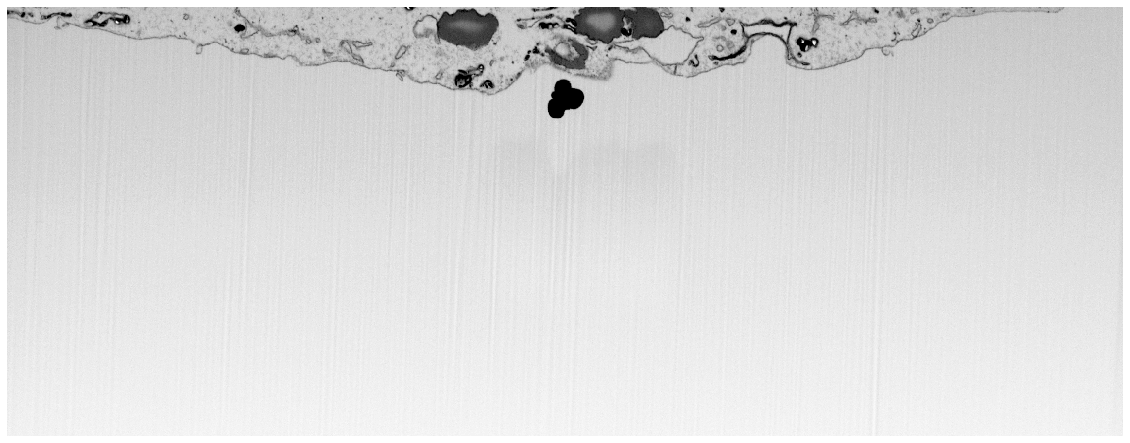

In [11]:
img = imread(rawimglist[rawfdlist[0]][0])
plt.figure(figsize = (20,20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

### Load the pre-trained model

In [12]:
model = load_model(path_model, custom_objects={'iou_coef': iou_coef, 'dice_coef': dice_coef})
print(model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [14]:
'''
learning_rate = 1e-5
loss = "binary_crossentropy"
metrics = ['accuracy', iou_coef, dice_coef]

dropout = 0.5
num_layers = 4
model = vanilla_unet_nodrop(
                            shape = (None, None), 
                            dropout = dropout, 
                            num_layers = num_layers, 
                            lr = learning_rate, 
                            loss = loss,
                            metrics = metrics,
                            summary = False,
                           )

model.load_weights(path_model)
'''

'\nlearning_rate = 1e-5\nloss = "binary_crossentropy"\nmetrics = [\'accuracy\', iou_coef, dice_coef]\n\ndropout = 0.5\nnum_layers = 4\nmodel = vanilla_unet_nodrop(\n                            shape = (None, None), \n                            dropout = dropout, \n                            num_layers = num_layers, \n                            lr = learning_rate, \n                            loss = loss,\n                            metrics = metrics,\n                            summary = False,\n                           )\n\nmodel.load_weights(path_model)\n'

### Set output folders

In [15]:
label = pars['inputclass'][0]
opdir = os.path.join(pred_path, 'pred_img')
fdnm_small = 'batch_small_fullsize' + '_' + model_predict_timestamp + '_' + run_number + 'demo'

def checkpredfolder(rawfdlist, opdir, opfolder, label):
    # folder name
    dir_checker(label, opdir)
    img_path_small = os.path.join(opdir, label)
    dir_checker(opfolder, img_path_small)

    # create folder list
    for folder in rawfdlist:
        dir_checker(folder, os.path.join(img_path_small, opfolder))

checkpredfolder(rawfdlist, opdir, fdnm_small, label)

nucleus exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_small_fullsize_2020_05_25_16_19_run-2demo does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\nucleus
data_d00_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\nucleus\batch_small_fullsize_2020_05_25_16_19_run-2demo


### Run Predictions


In [16]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    
    folder = rawfdlist[idx]
    
    print(folder)
    
    pred_input_imgs =  rawimglist_small[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_small, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)

data_d00_batch01_loc01
[[   0  256 2041 2297    0    9]
 [ 230  486 2041 2297    1    9]
 [ 460  716 2041 2297    2    9]
 [ 627  883    0  256    3    0]
 [ 627  883  230  486    3    1]
 [ 627  883  460  716    3    2]
 [ 627  883  690  946    3    3]
 [ 627  883  920 1176    3    4]
 [ 627  883 1150 1406    3    5]
 [ 627  883 1380 1636    3    6]
 [ 627  883 1610 1866    3    7]
 [ 627  883 1840 2096    3    8]
 [ 627  883 2041 2297    3    9]]


time for main: 7.9999940395355225
(864, 2272)
time for edge: 2.156249761581421
(13, 256, 256, 1)


C:\Users\wucci_admin\Documents\code\fibsem_seg_dl\core\imageprep.py:564: RuntimeWarning: Mean of empty slice
  outputimg = np.nanmean(img_stack_repos, axis = 0)


time for main: 0.7499957084655762
(864, 2272)
time for edge: 0.29687976837158203
(13, 256, 256, 1)
time for main: 0.7656228542327881
(864, 2272)
time for edge: 0.2968165874481201
(13, 256, 256, 1)
time for main: 0.7656252384185791
(864, 2272)
time for edge: 0.3125
(13, 256, 256, 1)
time for main: 0.7343759536743164
(864, 2272)
time for edge: 0.31249570846557617
(13, 256, 256, 1)
time for main: 0.7813067436218262
(864, 2272)
time for edge: 0.2812535762786865
(13, 256, 256, 1)
time for main: 0.734368085861206
(864, 2272)
time for edge: 0.29682087898254395
(13, 256, 256, 1)
time for main: 0.7499997615814209
(864, 2272)
time for edge: 0.2968752384185791
(13, 256, 256, 1)
time for main: 0.7812521457672119
(864, 2272)
time for edge: 0.312497615814209
(13, 256, 256, 1)


C:\Users\wucci_admin\Anaconda3\envs\tfdl02\lib\site-packages\skimage\external\tifffile\tifffile.py:2618: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


time for main: 0.7500004768371582
(864, 2272)
time for edge: 0.28125
(13, 256, 256, 1)
time for main: 0.7968342304229736
(864, 2272)
time for edge: 0.3124821186065674
(13, 256, 256, 1)
time for main: 0.7500019073486328
(864, 2272)
time for edge: 0.2968759536743164
(13, 256, 256, 1)
time for main: 0.765625
(864, 2272)
time for edge: 0.296891450881958
(13, 256, 256, 1)
time for main: 0.7500014305114746
(864, 2272)
time for edge: 0.2656829357147217
(13, 256, 256, 1)
time for main: 0.7655682563781738
(864, 2272)
time for edge: 0.3125
(13, 256, 256, 1)
time for main: 0.7656269073486328
(864, 2272)
time for edge: 0.2968721389770508
(13, 256, 256, 1)
time for main: 0.7656280994415283
(864, 2272)
time for edge: 0.3125033378601074
(13, 256, 256, 1)
time for main: 0.7656211853027344
(864, 2272)
time for edge: 0.296877384185791
(13, 256, 256, 1)
time for main: 0.75
(864, 2272)
time for edge: 0.2968738079071045
(13, 256, 256, 1)
time for main: 0.7499997615814209
(864, 2272)
time for edge: 0.296875

## Prediction Dataset with tiles (whole stack)
### Create Folder 

In [17]:
# folder name
fdnm_total = 'batch_total_fullsize' + '_' + model_predict_timestamp + '_' + run_number
checkpredfolder(rawfdlist, opdir, fdnm_total, label)

nucleus exists in D:PerlmutterData\dl_seg_project_raw\pred_img
batch_total_fullsize_2020_05_25_16_19_run-2 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\nucleus
data_d00_batch01_loc01 does not exist in D:PerlmutterData\dl_seg_project_raw\pred_img\nucleus\batch_total_fullsize_2020_05_25_16_19_run-2


### Tiling Prediction with Stack Input
- Crop image into patched by a given overlap factor
- Export a cropping index
- Construct patches back into a image 

In [18]:
from core.imageprep import create_crop_idx, crop_to_patch
from core.train_predict import stack_predict_v2

for idx in trange(len(rawfdlist)):
    
    folder = rawfdlist[idx]
    
    pred_input_imgs =  rawimglist[folder]
    pred_output_path = os.path.join(opdir, label, fdnm_total, folder)
    
    img = imread(rawimglist_small[folder][0])
    cropidx = create_crop_idx_whole(img.shape, (IMG_HEIGHT, IMG_WIDTH), overlap_fac = 0.1)
    print(cropidx)
    
    stack_predict_v2(
                input_imgpath = pred_input_imgs, 
                output_imgpath = pred_output_path, 
                cropidx = cropidx, 
                model = model, 
                rescale = 1./255.,
                patch_size = (IMG_HEIGHT, IMG_WIDTH), 
                predict_threshold = 0.5)


[[   0  256 2041 2297    0    9]
 [ 230  486 2041 2297    1    9]
 [ 460  716 2041 2297    2    9]
 [ 627  883    0  256    3    0]
 [ 627  883  230  486    3    1]
 [ 627  883  460  716    3    2]
 [ 627  883  690  946    3    3]
 [ 627  883  920 1176    3    4]
 [ 627  883 1150 1406    3    5]
 [ 627  883 1380 1636    3    6]
 [ 627  883 1610 1866    3    7]
 [ 627  883 1840 2096    3    8]
 [ 627  883 2041 2297    3    9]]


time for main: 0.7656245231628418
(864, 2272)
time for edge: 0.2812507152557373
(13, 256, 256, 1)
time for main: 0.7812483310699463
(864, 2272)
time for edge: 0.2968771457672119
(13, 256, 256, 1)
time for main: 0.750046968460083
(864, 2272)
time for edge: 0.2968885898590088
(13, 256, 256, 1)
time for main: 0.7813107967376709
(864, 2272)
time for edge: 0.2968733310699463
(13, 256, 256, 1)
time for main: 0.7343740463256836
(864, 2272)
time for edge: 0.2968757152557373
(13, 256, 256, 1)
time for main: 0.75
(864, 2272)
time for edge: 0.2968790531158447
(13, 256, 256, 1)
time for main: 0.7500033378601074
(864, 2272)
time for edge: 0.3124971389770508
(13, 256, 256, 1)
time for main: 0.7656135559082031
(864, 2272)
time for edge: 0.296875
(13, 256, 256, 1)
time for main: 0.75
(864, 2272)
time for edge: 0.2968752384185791
(13, 256, 256, 1)
time for main: 0.7647173404693604
(864, 2272)
time for edge: 0.2968735694885254
(13, 256, 256, 1)
time for main: 0.7500045299530029
(864, 2272)
time for edge

KeyboardInterrupt: 